In [89]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import colors
import matplotlib
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from scipy import interpolate
import re

In [2]:
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, RIVERS
import seaborn as sns
from shapely.geometry import LinearRing, MultiPoint, MultiPolygon
from shapely.geometry.point import Point
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
from descartes import PolygonPatch

In [3]:
scale = '50m'

plt.rcParams.update({'mathtext.default':  'regular' })

class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

In [4]:
direc = '/u/home/gergel/agu_runs/reg_run'
test_filename = 'fluxes_daily.1989-09-01.nc'

also need a statefile for nodal depths 

In [5]:
direc_statefile = '/u/home/gergel/agu_runs'
statefile = 'vic5.RI_CRUNCEP.agu_run.20171119a.19940901_00000.nc'

look at statefile nodal depths 

In [6]:
statefile_states = xr.open_dataset(os.path.join(direc_statefile, statefile))
node_depths = statefile_states.node_depth[:, 63, 130]
node_depths_arr = statefile_states.node_depth[:, 63, 130].values

In [7]:
params = xr.open_dataset(os.path.join('/u/home/gergel','vic_params_wr50a_vic5.0.dev_20160328.nc'))
land_mask = params.run_cell
land_mask.coords['xc'] = params.xc
land_mask.coords['yc'] = params.yc

load test dataset 

In [8]:
fluxes = xr.open_dataset(os.path.join(direc, test_filename))
soil_temps = fluxes.OUT_SOIL_TNODE
soil_temps_node = soil_temps.isel(node=8)

How to estimate extent of modeled permafrost (From Slater and Lawrence 2013)

For those models that provide soil temperatures, ‘‘near-surface’’ permafrost can be diagnosed as such: if soil at a depth within 3.5 m of the surface (based on the lower boundary of a model’s soil layers) maintains a temperature of 0 degrees C or less for the present and prior year, it is considered to contain permafrost. This defi- nition (designated here as TSL) was chosen because active layers rarely reach this depth and it is within the range of most model soil depths.

print out node depths (homogeneous across RASM domain)

In [9]:
node_depths_arr

array([ 0.        ,  0.19581318,  0.42996919,  0.70997596,  1.04481173,
        1.44521284,  1.92401767,  2.49657893,  3.18125534,  4.        ])

calculate monthly means from daily means 

In [10]:
# use this to calculate active layer depth in later step (and then take the max ALT for each year)
monthly_mean_soil_temp = soil_temps.resample(freq = 'm', dim = 'time', how = 'mean')

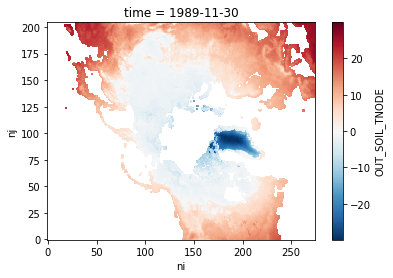

In [11]:
monthly_mean_soil_temp.isel(time=2).isel(node=9).plot()

mean for each year

In [12]:
annual_mean_temp_node = soil_temps_node.groupby('time.year').mean(dim='time')

In [13]:
mean_temp_node = soil_temps_node.mean(dim='time')

mean across all years 

In [14]:
mean_annual_mean_temp_node = annual_mean_temp_node.mean(dim='year')

max across all years 

In [15]:
max_annual_mean_temp_node = annual_mean_temp_node.max(dim='year')
max_annual_mean_temp_node.coords['xc'] = fluxes.xc
max_annual_mean_temp_node.coords['yc'] = fluxes.yc

min across all years 

In [16]:
min_annual_mean_temp_node = annual_mean_temp_node.min(dim='year')
min_annual_mean_temp_node.coords['xc'] = fluxes.xc
min_annual_mean_temp_node.coords['yc'] = fluxes.yc

plot where there is permafrost 

figure out number of gridcells in RASM domain where there is permafrost 

In [17]:
# figure out number of gridcells where there is permafrost 
permafrost_mask = np.int32(max_annual_mean_temp_node <- 0)

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [18]:
no_gridcells_permafrost = permafrost_mask.sum()
area_permafrost = no_gridcells_permafrost * 2500.00 # 50km x 50km gridcells 
print ('We have {0:.2f} km2 of permafrost for these years in the RASM domain'.format(area_permafrost))

We have 23397500.00 km2 of permafrost for these years in the RASM domain


In [19]:
discont_permafrost_mask = np.int32(min_annual_mean_temp_node <- 0)

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


## Figure of Continuous and Discontinuous Permafrost Across RASM Domain ## 

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


([], <a list of 0 Text yticklabel objects>)

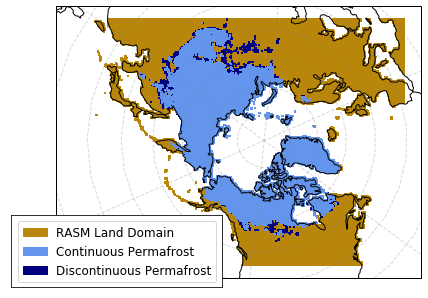

In [20]:
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw=dict(projection=Rasm()))

land_color = "darkgoldenrod"
discont_color = "navy"
cont_color = "cornflowerblue"
cmap3 = colors.ListedColormap(land_color)    
cmap2 = colors.ListedColormap(discont_color)
cmap1 = colors.ListedColormap(cont_color)

land_mask.plot.pcolormesh('xc', 'yc', cmap=cmap3, 
                          add_colorbar=False, 
                          add_labels=False,
                          transform=ccrs.PlateCarree())
min_annual_mean_temp_node.where(min_annual_mean_temp_node <- 0).plot.pcolormesh('xc', 'yc',
                                                                                cmap=cmap2, 
                                                                                add_labels=False, 
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())
max_annual_mean_temp_node.where(max_annual_mean_temp_node <- 0).plot.pcolormesh('xc', 'yc',
                                                                                cmap=cmap1, 
                                                                                add_labels=False, 
                                                                                add_colorbar=False,
                                                                                transform=ccrs.PlateCarree())
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax.coastlines()

# create patches for inset axes
p_land = mpatches.Patch(color=land_color, label='RASM Land Domain')
p_cont = mpatches.Patch(color=cont_color, label='Continuous Permafrost')
p_discont = mpatches.Patch(color=discont_color, label='Discontinuous Permafrost')

# this is an inset axes over the main axes
leg_axes = plt.axes([0.06, 0.1, .42, .2], facecolor='white')
leg_axes.legend(handles=[p_land, p_cont, p_discont], prop={'size':12})
plt.xticks([])
plt.yticks([])


## 35-year climatology of frozen area, with shaded area representing the range associated with interannual variability ##

In [21]:
# soil_temps_node.groupby('time.year').mean(dim='time')
min_months = soil_temps_node.groupby('time.month').min(dim='time')
mean_months = soil_temps_node.groupby('time.month').mean(dim='time')
max_months = soil_temps_node.groupby('time.month').max(dim='time')

In [22]:
# minimum temperatures corresponds to maximum permafrost area
min_area = []
for month in np.arange(0, 12): 
    permafrost_mask = np.int32(max_months.isel(month=month) <- 0)
    no_gridcells_permafrost = permafrost_mask.sum()
    area_permafrost = no_gridcells_permafrost * 2500.00 # 50km x 50km gridcells 
    min_area.append(area_permafrost)
    
# maximum temperatures corresponds to minimum permafrost area
max_area = []
for month in np.arange(0, 12): 
    permafrost_mask = np.int32(min_months.isel(month=month) <- 0)
    no_gridcells_permafrost = permafrost_mask.sum()
    area_permafrost = no_gridcells_permafrost * 2500.00 # 50km x 50km gridcells 
    max_area.append(area_permafrost)
mean_area = []
for month in np.arange(0, 12): 
    permafrost_mask = np.int32(mean_months.isel(month=month) <- 0)
    no_gridcells_permafrost = permafrost_mask.sum()
    area_permafrost = no_gridcells_permafrost * 2500.00 # 50km x 50km gridcells 
    mean_area.append(area_permafrost)

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


(0, 11)

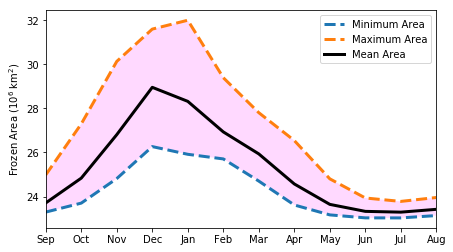

In [23]:
import matplotlib.ticker as mtick
unit_conv = 10 ** -6
lw = 3.0
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
month_nums = np.arange(0, 12)
max_area_conv = [i * unit_conv for i in max_area]
min_area_conv = [i * unit_conv for i in min_area]
mean_area_conv = [i * unit_conv for i in mean_area]
plt.plot(month_nums, min_area_conv, '--', linewidth=lw, label='Minimum Area')
plt.plot(month_nums, max_area_conv, '--', linewidth=lw, label='Maximum Area')
ax.fill_between(month_nums, min_area_conv, max_area_conv, facecolor="magenta", alpha=0.15)
plt.plot(month_nums, mean_area_conv, '-', linewidth=lw, color='k', label='Mean Area')
plt.ylabel("Frozen Area ($10^6$ $km^2$)")
months = ['Sep', 'Oct', 'Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
plt.xticks(month_nums, months, rotation='horizontal')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim([0, 11])

## ALT over the RASM domain, using Monthly Means 

In [24]:
'''elif np.abs(ynew[ind]) > 0.05:
            # no 0 degree isotherm
            return(xr.DataArray(-999))'''

'elif np.abs(ynew[ind]) > 0.05:\n            # no 0 degree isotherm\n            return(xr.DataArray(-999))'

In [44]:
'''def spline_interp(x):
    if np.isnan(x).any() != True:
        tck = interpolate.splrep(node_depths, x, s=0)
        xnew = np.linspace(0, node_depths.max(), len(node_depths_arr)*20)
        ynew = interpolate.splev(xnew, tck, der=0)
        ind = np.argmin(np.abs(ynew))
        depth = xnew[ind]
        if (np.abs(ynew[ind]) > 0.05 and x.all() < 0):
            # super cold temps, e.g. Greenland should have permafrost!
            return(xr.DataArray(0.0))
        elif (np.abs(ynew[ind] < 0.05)) and (x.all() > 0): 
            # temp close to 0 but no inflection point 
            return(xr.DataArray(-999))
        elif np.abs(ynew[ind]) > 0.05: 
            # temp not close to 0 and no inflection point
            return(xr.DataArray(-999))
        else:
            # return 0 deg isotherm depth associated with it
            return(xr.DataArray(depth))
    else: 
        return(xr.DataArray(-99.0))'''

In [63]:
def spline_interp(x):
    if np.isnan(x).any() != True:
        tck = interpolate.splrep(node_depths, x, s=0)
        xnew = np.linspace(0, node_depths.max(), len(node_depths_arr)*20)
        ynew = interpolate.splev(xnew, tck, der=0)
        ind = np.argmin(np.abs(ynew))
        depth = xnew[ind]
        if x.values.max() < 0:
            # super cold temps, e.g. Greenland should have permafrost!
            return(xr.DataArray(0.0))
        elif x.values.min() > 0: 
            # temp close to 0 but no inflection point 
            return(xr.DataArray(-999))
        else:
            # return 0 deg isotherm depth associated with it
            return(xr.DataArray(depth))
    else: 
        return(xr.DataArray(-99.0))

SUPER RELEVANT example from the Google Groups Page on Xarray: https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe

select out August from timeseries

In [78]:
def is_august(month):
    return (month == 8) 

august_mean_soil_temp = monthly_mean_soil_temp.sel(time=is_august(monthly_mean_soil_temp['time.month']))

In [84]:
# stack time, lat and lon into a single dimension called allpoints
# stacked_da = soil_temps[0, :, :, :].stack(allpoints=['nj', 'ni'])
stacked_da = august_mean_soil_temp.stack(allpoints=['time', 'nj', 'ni'])

In [85]:
# apply the function over allpoints to calculate the 0 degree isotherm at each time-space point 
alt_stacked = stacked_da.groupby('allpoints').apply(spline_interp)

In [86]:
# unstack it to be a space-time DataArray 
alt_unstacked = alt_stacked.unstack('allpoints')

In [87]:
# groupby year, take max across all months in a year, and then take the mean ALT across all years 
annual_max_alt = alt_unstacked.groupby('time.year').max(dim='time').mean(dim='year')
# add xc and yc coordinates for use in pcolormesh
annual_max_alt.coords['xc'] = fluxes.xc
annual_max_alt.coords['yc'] = fluxes.yc

([], <a list of 0 Text yticklabel objects>)

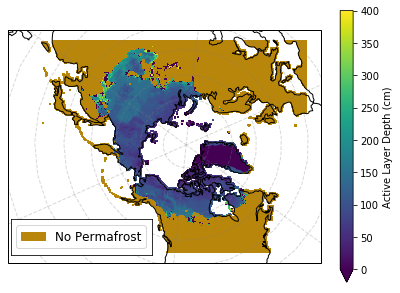

In [88]:
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw=dict(projection=Rasm()))

'''(annual_max_alt.where((annual_max_alt != -99) & (annual_max_alt != -999)) * 100).plot.pcolormesh('xc', 'yc',
                                                                                              robust=True, 
                                                                    cbar_kwargs={'label': 'Active Layer Depth (cm)'}, 
                                                                                              add_labels=False, 
                                                                    transform=ccrs.PlateCarree(),
                                                                    vmin=0, 
                                                                    vmax=400)'''

(annual_max_alt.where(annual_max_alt != -99) * 100).plot.pcolormesh('xc', 'yc',
                                                                                              robust=True, 
                                                                    cbar_kwargs={'label': 'Active Layer Depth (cm)'}, 
                                                                                              add_labels=False, 
                                                                    transform=ccrs.PlateCarree(),
                                                                    vmin=0, 
                                                                    vmax=400)

annual_max_alt.where(annual_max_alt == -999).plot.pcolormesh('xc', 'yc',
                                                           cmap=cmap3, 
                                                           add_colorbar=False, 
                                                           add_labels=False,
                                                           transform=ccrs.PlateCarree())

plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')

g1 = ax.coastlines()

# create land line patch for inset axes
p = mpatches.Patch(color=land_color, label='No Permafrost')

# this is an inset axes over the main axes
leg_axes = plt.axes([0.13, 0.2, .28, .1], facecolor='white')
leg_axes.legend(handles=[p], prop={'size':12})
plt.xticks([])
plt.yticks([])